# Predicting Procurement Compliance Using KPI-Driven Machine Learning Models
**Author:** Brittany Dowdle

**Date:** 8/5/2025

**Objective:** This notebook is part of the overall capstone project. The ultimate goal is to identify patterns and predictors of non-compliant suppliers using machine learning techniques.

## Introduction
This project uses the [Procurement KPI Analysis Dataset](https://www.kaggle.com/datasets/shahriarkabir/procurement-kpi-analysis-dataset) to predict compliance of suppliers. The dataset includes purchase order records from 5 different suppliers from 2022-2023. Using the cleaned data set prepared in [cleaning.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/cleaning.ipynb), explored in [EDA.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/EDA.ipynb), and modeled in [modeling.ipynb](https://github.com/Bdowdle4/Dowdle_Analytics_Capstone/blob/main/Notebooks/modeling.ipynb) this notebook focuses on the "next steps" section mentioned there to improve non-compliant predictions. The peer review I received suggested I implement one of those steps to strengthen the model's real-world applicability.

****

## Imports
In the code cell below are the necessary Python libraries for this notebook. *All imports should be at the top of the notebook.*

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc, brier_score_loss
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from sklearn.utils import estimator_html_repr
from IPython.display import display, HTML
from sklearn.calibration import calibration_curve, CalibrationDisplay
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

****
### 1. Load the Cleaned Dataset

In [2]:
# Load the dataset
df = pd.read_csv("C:/Users/Britt/Documents/44688/Dowdle_Analytics_Capstone/Data/cleaned_procurement_data.csv")

# Convert target variable to numeric
df['compliance'] = df['compliance'].map({'Yes': 1, 'No': 0})

print(df['compliance'].value_counts())

compliance
1    623
0    135
Name: count, dtype: int64


### 2. Define Features and Targets

In [3]:
# Define column groups (using all features)
categorical_cols = ['supplier', 'item_category', 'order_status']
numeric_cols = ['quantity', 'unit_price', 'negotiated_price', 'defective_units', 'price_diff', 'defect_rate', 'lead_time_days']

# Define preprocessing for each column type
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine into full column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

### 3. Split the Dataset

In [4]:
# Split the data (Stratified)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in split.split(df[categorical_cols + numeric_cols], df['compliance']):
    X_train = df.iloc[train_idx][categorical_cols + numeric_cols]
    y_train = df.iloc[train_idx]['compliance']
    X_test = df.iloc[test_idx][categorical_cols + numeric_cols]
    y_test = df.iloc[test_idx]['compliance']  

# Show row counts
print("Training set size:", X_train.shape[0])
print("Test set size:", X_test.shape[0])  

Training set size: 606
Test set size: 152


### 4.  Use class_weight='balanced' in Random Forest Model

In [5]:
rf_balanced = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=5,
        min_samples_split=4,
        class_weight='balanced',
        random_state=42
    ))
])

rf_balanced.fit(X_train, y_train)
y_pred_rf_balanced = rf_balanced.predict(X_test)

# Predict class probabilities for ROC AUC
y_proba_rf_balanced = rf_balanced.predict_proba(X_test)[:, 1]

# Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred_rf_balanced))

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_proba_rf_balanced)
print(f"ROC AUC Score: {roc_auc:.4f}")

=== Classification Report ===
              precision    recall  f1-score   support

           0       0.39      0.56      0.46        27
           1       0.89      0.82      0.85       125

    accuracy                           0.77       152
   macro avg       0.64      0.69      0.66       152
weighted avg       0.81      0.77      0.78       152

ROC AUC Score: 0.7464


### 5. Plot the Calibration Curve

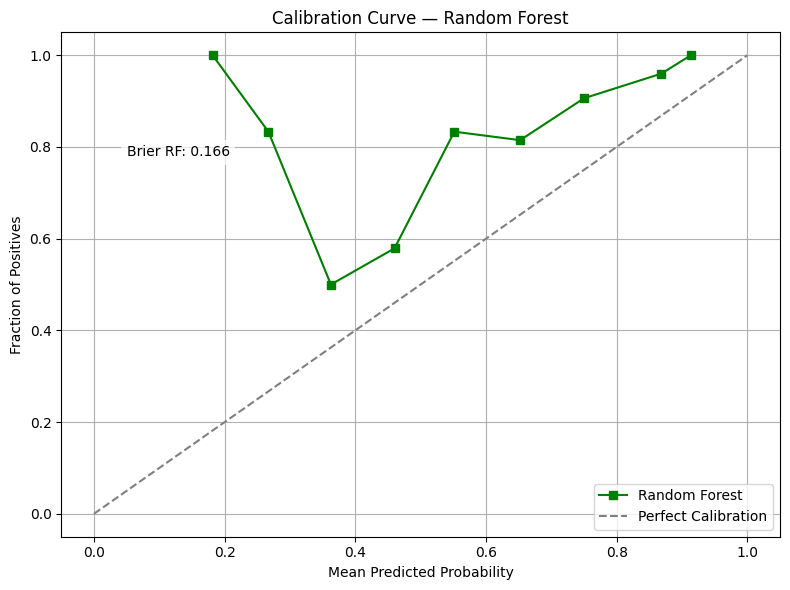

In [10]:
# Compute the calibration curve
prob_true_rf, prob_pred_rf = calibration_curve(
    y_test,
    y_proba_rf_balanced,
    n_bins=10,
    strategy='uniform'
)

# Compute Brier score
brier_rf = brier_score_loss(y_test, y_proba_rf_balanced)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(
    prob_pred_rf,
    prob_true_rf,
    marker='s',
    color='green',
    label='Random Forest'
)
plt.plot(
    [0, 1],
    [0, 1],
    linestyle='--',
    color='gray',
    label='Perfect Calibration'
)
# Annotate Brier score
plt.text(
    0.05, 0.78,
    f'Brier RF: {brier_rf:.3f}',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
)

plt.title("Calibration Curve — Random Forest")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6. Visualize the Confusion Matrix

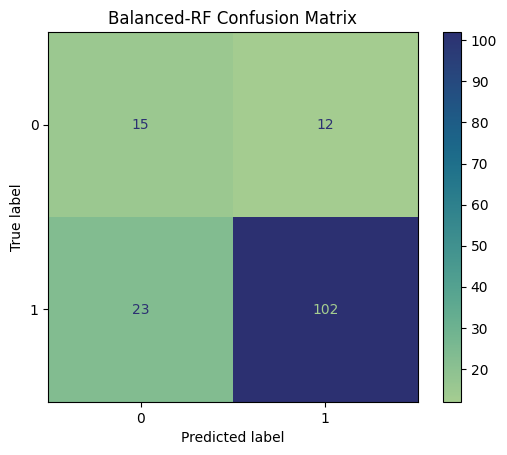

In [12]:
ConfusionMatrixDisplay.from_estimator(
    rf_balanced, 
    X_test, 
    y_test, 
    cmap='crest'
)
plt.title("Balanced-RF Confusion Matrix")
plt.show()

### 7. Plot the ROC Curve

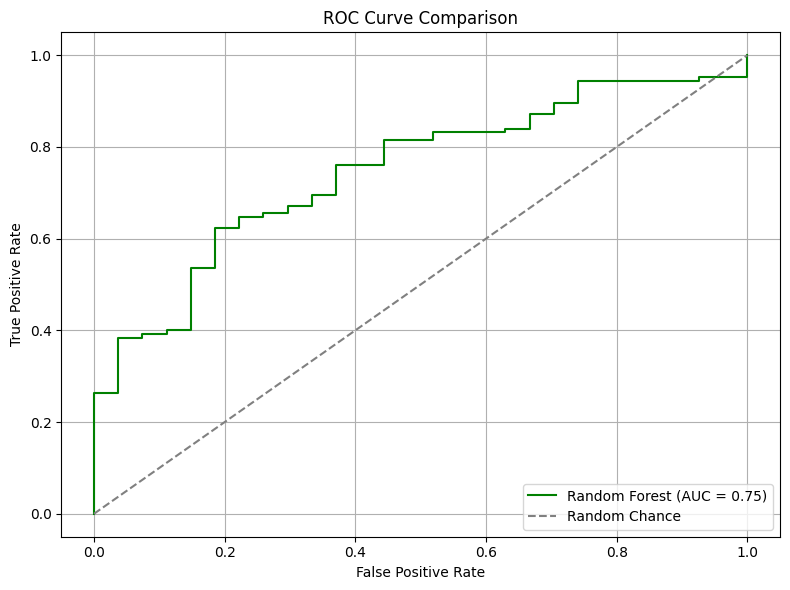

In [13]:
# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf_balanced)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC Curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Chance')

# Plot styling
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

****

### 8. Conclusion